# Creating Hurricane Cone Shape Maps in Python



This jupyter notebook is how I would go about creating shapefiles for hurricane wind speed and also some primitive data visualizations in python.

### Package Loading and Data Importing

I've went ahead and uploaded a cleaned version of the historical hurricane data to the github, and you can pull it down from there. Feel free to use another datasource if you think it would be more appropriate. For the county boundaries, we can pull that from the census site.

In [8]:
#General data stuff
import pandas as pd
#Used to calculate the shapefile X nautical miles away from hurricane center
import geopy 
import geopy.distance
from geopy.distance import geodesic
#Used to make the shapefile and test intersection
import shapely
from shapely.geometry import Polygon
from shapely.geometry import shape
#Used to make our graphs and draw polygons
import geopandas as gpd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from shapely.ops import unary_union

In [14]:
#Read in our historical hurricane track data
hurricane_df = pd.read_csv(r'https://raw.githubusercontent.com/JackOgozaly/Hurricane_Crop_Acreage/main/Data/historical_hurricane_date.csv')
#Bring in our county shapes
shapes = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')
#Subset for just irma
hurricane_irma = hurricane_df[hurricane_df['id'] == 'AL112017']

### Shape Files

Essentialy, NOAA gives you data about where the center of the storm is and then wind speeds X nautical miles out. What we need to do is take that data, create a polygon, and then we'll be able to see if a county's polygon intersects. This function here goes ahead and does that for you.

In [12]:
def hurricane_shape (lat, long, quadrant_miles,
                     bearings = {0: 45, 1:135, 2:225, 3:315}):
    '''
    Creates a shape file for wind speeds of a hurricane
    Parameters
    ----------
    lat : FLOAT
        Latitude for center of storm
    long : FLOAT
        Longitude for center of storm
    quadrant_miles : LIST
        X nautical miles away from storm where wind is felt, should be passed in order
        North East, South East, Southwest, North West
    bearings : DICT
        Map of quadrants to bearings   
    
    Returns
    -------
    Shape file for hurricane wind speeds
    '''
    center = geopy.Point(lat, long)
    shapefile = []
    for i in range(len(quadrant_miles)):
        if quadrant_miles[i] is None:
            shapefile.append(None)
        else:
            d = geodesic(nautical = quadrant_miles[i]).destination(point=center, bearing=bearings[i])
            
            shapefile.append((d.longitude, d.latitude))

    return shapefile

Now, we just want to subset our dataframe for our hurricane force winds, and iterate through to create our polygons for every time.

In [15]:
#Subset for only hurricane irma data where it was a hurricane
hurricane_force = hurricane_irma[hurricane_irma['status_of_system_desc'] == 'HU – Tropical cyclone of hurricane intensity (> 64 knots)'].copy()

#Create a list of our columns
latitude = list(hurricane_force['latitude'])
longitude = list(hurricane_force['longitude'])
north_east = list(hurricane_force['64kt_wind_radii_NE_quad'])
south_east = list(hurricane_force['64kt_wind_radii_SE_quad'])
south_west = list(hurricane_force['64kt_wind_radii_SW_qud'])
north_west = list(hurricane_force['64kt_wind_radii_NW_qud'])

#Empty list to put our polygons
irma_poly_list = []

#Loop through and for every observation create a shapefile
for i in range(len(north_east)):
    sub_poly = hurricane_shape(latitude[i],longitude[i],
                    [north_east[i], south_east[i], south_west[i], north_west[i]])
    
    sub_poly= shape({'type': "Polygon", "coordinates": [sub_poly]})
    
    irma_poly_list.append(sub_poly)

### Simple Data Visualization

This first graph shows us the collection of polygons we have for hurricane force winds for Irma.

Text(0.5, 1.0, 'Hurricane Irma Hurricane Force Winds Shapefile')

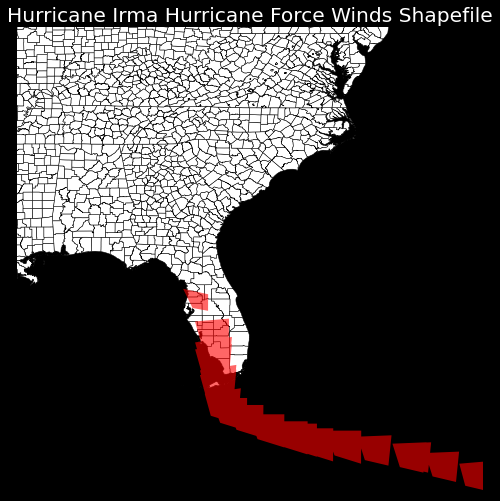

In [45]:
#This is just for decoration
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,8))

#Create our county shapefiles and plot them
counties = gpd.GeoSeries(shapes['geometry'])
counties.plot(ax=ax, color='white', edgecolor='black')
#Combine our many smaller irma polygons into one multipolygon
irma_poly = unary_union(irma_poly_list)
#Convert to geoseries and plot
p = gpd.GeoSeries(irma_poly)
p.plot(ax=ax, color = "red", alpha = .6)

#This is also just for decoration
plt.xlim([-90, -70])
plt.ylim([20, 40])
plt.axis('off')
plt.title("Hurricane Irma Hurricane Force Winds Shapefile")

In this next section, we can test to see what counties overlap with our multipolygon and then visualize those!

Text(0.5, 1.0, 'Counties Affected By Hurricane Force Winds During Hurricane Irma')

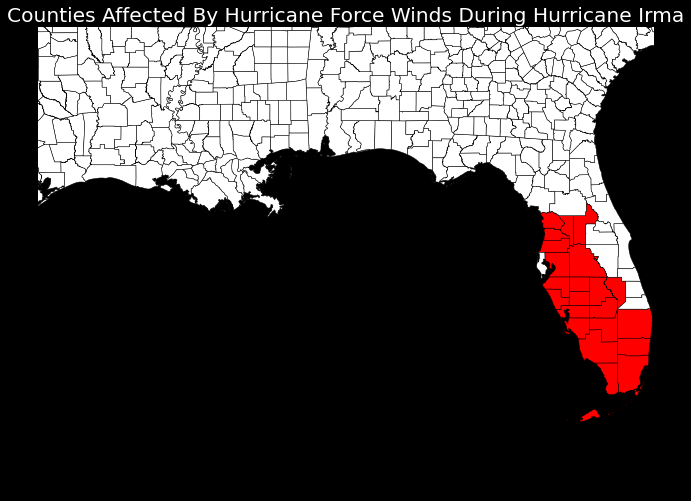

In [42]:
#Create an empty list to store our intersect values
intersects_list = []
for i in range(len(counties)):
    p1 = counties.iloc[i]
    #Store a list of True or False for if that county intersected with Irma
    intersects_list.append(p1.intersects(irma_poly))

#Create our figure and color map
fig, ax = plt.subplots(figsize=(12,8))
cmap =LinearSegmentedColormap.from_list('wr',["w", "r"], N=2)

#Add our impacted variable to our county shapes file
shapes2 = shapes.copy()
shapes2['Impacted'] = pd.Series(intersects_list).astype(int)

#Create a geodataframe from our county shape info
counties_shapes = gpd.GeoSeries(shapes2['geometry'])
gdf = gpd.GeoDataFrame(shapes2, geometry=counties_shapes)
#Plot that data
gdf.plot(ax=ax, column= 'Impacted', edgecolor='black', cmap= cmap)

#This is also just for decoration
plt.xlim([-95, -80])
plt.ylim([23, 33])
plt.axis('off')
plt.title("Counties Affected By Hurricane Force Winds During Hurricane Irma")